In [58]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pysindy as ps
from functions import Rossler, Solution, plot
from ae import Autoencoder

In [59]:
a, b, c = 0.15, 0.2, 10
h = np.pi/100
t = np.arange(0,100,h)
n = len(t)
x0 =np.array([0,1,0])
xs,ys,zs = Solution(Rossler, x0, t, [a,b,c])
tau = 20

In [60]:
v1 = np.array(xs[0: n - 2*tau]) #x(t)
v2 = np.array(xs[tau: n - tau]) #x(t + τ)
v3 = np.array(xs[2*tau: n]) #x(t + 2τ)

dv1 = np.gradient(v1, t[:len(v1)])
dv2 = np.gradient(v2, t[:len(v1)])
dv3 = np.gradient(v3, t[:len(v1)])

In [61]:
torch.manual_seed(123)

In [62]:
v = torch.tensor(np.array([v1, v2, v3]), dtype=torch.float32, requires_grad=True).T
dvdt = torch.tensor(np.array([dv1, dv2, dv3]), dtype=torch.float32, requires_grad=True).T
input_dim = 3
latent_dim = 3
autoencoder = Autoencoder(tau, l={'l1': 1, 'l2': 1, 'l3': 0, 'l4': 0, 'l5': 0, 'l6': 0, 'l_rossler': 0})
learning_rate = 1e-3
num_epochs = 1000
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [63]:
for epoch in range(num_epochs):
    Loss = autoencoder.loss(v, dvdt, criterion)
    optimizer.zero_grad()
    Loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Loss.item():.4f}')

Epoch [100/1000], Loss: 5.3179
Epoch [200/1000], Loss: 0.2723
Epoch [300/1000], Loss: 0.1917
Epoch [400/1000], Loss: 0.1409
Epoch [500/1000], Loss: 0.0733
Epoch [600/1000], Loss: 0.0292
Epoch [700/1000], Loss: 0.0160
Epoch [800/1000], Loss: 0.0279
Epoch [900/1000], Loss: 0.0094
Epoch [1000/1000], Loss: 0.0081


In [64]:
autoencoder.eval() 
latent_variables = autoencoder.encode(v) 

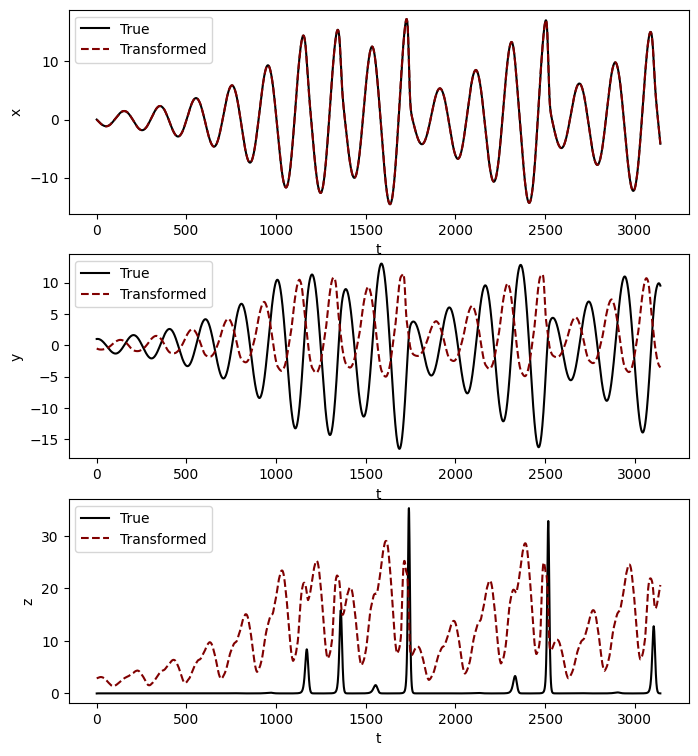

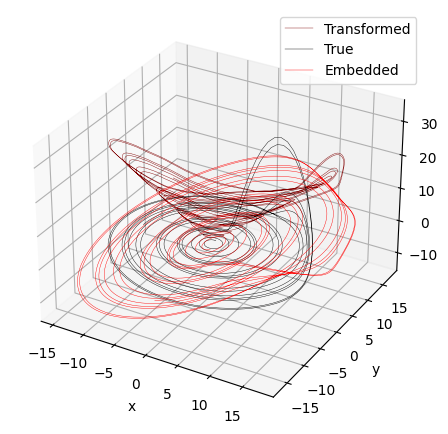

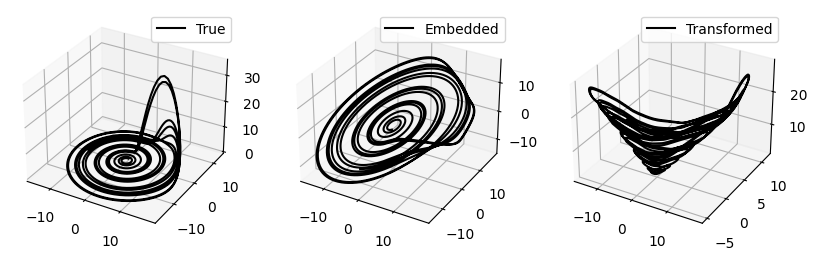

In [65]:
x_ae = latent_variables[:,0].detach().numpy()
y_ae = latent_variables[:,1].detach().numpy()
z_ae = latent_variables[:,2].detach().numpy()

plot(xs, ys, zs, v1, v2, v3, x_ae, y_ae, z_ae)

(3144, 3)
(*x)' = 0.726 1 + -0.963 *x + 2.116 *y + -0.360 *z + 0.038 *x *y
(*y)' = 0.441 1 + -0.717 *x + 0.757 *y + -0.115 *z + -0.039 *x *y + 0.040 *y^2
(*z)' = -1.964 1 + 0.161 *x + 0.265 *y + 0.403 *z + -0.140 *x^2 + 0.170 *x *y + 0.030 *y^2


c:\Users\USAID\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


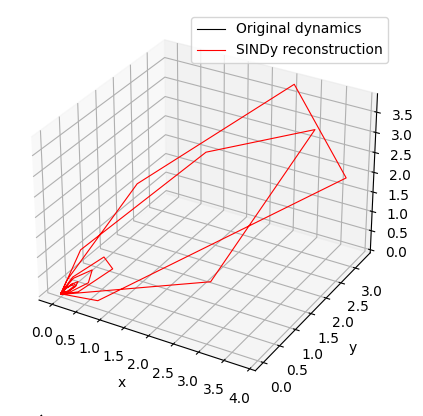

In [66]:
X = np.array([x_ae, y_ae, z_ae]).T
print(X.shape)

diff_method = ps.FiniteDifference(order = 1)
feature_library = ps.PolynomialLibrary(degree = 2)
optimizer = ps.STLSQ(threshold=0.02)

model = ps.SINDy(
    differentiation_method=diff_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["*x", "*y", "*z"],
)

model.fit(X, t[:len(x_ae)])
model.print()

def SINDy_equs(X, t, P):
    x, y, z = X
    dx =  1.115 + 1.040 *x + -1.231 *y + 1.966 *z + 0.027 *x**2 + 0.077 *x *z + 0.022 *y *z + 0.026 *z**2
    dy = -0.816 + -0.483 *x + 0.212 *y + -0.537 *z + -0.033 *x**2 + -0.037 *y *z + 0.033 *z**2
    dz = -0.700 *x + 1.765 *y + -1.233 *z + 0.059 *x *y + -0.040 *x *z
    return dx, dy, dz

x_si, y_si, z_si = Solution(SINDy_equs, [x_ae[0], y_ae[0], z_ae[0]], t[:len(x_ae)], [0,0,0])

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection = '3d')
ax.plot(xs[:len(x_si)], ys[:len(x_si)],zs[:len(x_si)], lw = .8, color = 'k', label = "Original dynamics")
ax.plot(x_si, y_si, z_si,color = 'r', lw = .8, label = "SINDy reconstruction")
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_zlabel("z")
plt.legend()
plt.show()